In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 20})

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *

# To activate logging
setup_logging()

## Cosmology

In [2]:
z = 1.175

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

k=np.logspace(-5, 3, 100000)

## Gaussian mock to compare to model

In [3]:
output_dir = '/feynman/work/dphp/mp270220/outputs/'

In [4]:
cellsize = 10
resampler = 'tsc'

In [5]:
mocks_density_list = list()
data_densities = list()
mesh_densities = list()
nbar_list = list()
shot_noise_list = list()

for i in range(10):
    mock = catalog_data.Data.load(output_dir+'mocks/gaussian/AbacusSummit_1Gpc_z1.175_gaussianMock{}_truncatedPk_nbarx5.npy'.format(i))
    mock_density = density_split.DensitySplit(mock)
    mock_density.compute_density(cellsize=cellsize, resampler=resampler, use_rsd=False, use_weights=True)
    data_densities.append(mock_density.data_densities)
    mesh_densities.append(np.array(mock_density.density_mesh))
    
    nbar = mock.size/mock.boxsize**3
    nbar_list.append(nbar)
    shot_noise = np.mean((mock.weights)**2)/nbar
    shot_noise_list.append(shot_noise)
    
nbar = np.mean(np.array(nbar_list))
shot_noise = np.mean(np.array(shot_noise_list))

[000002.36]  06-27 09:38  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 14674610.
[000003.47]  06-27 09:38  CatalogMesh                  INFO     Painted 4194304 out of 14674610 objects to mesh.
[000003.47]  06-27 09:38  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 14674610.
[000004.56]  06-27 09:38  CatalogMesh                  INFO     Painted 8388608 out of 14674610 objects to mesh.
[000004.56]  06-27 09:38  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 14674610.
[000005.66]  06-27 09:38  CatalogMesh                  INFO     Painted 12582912 out of 14674610 objects to mesh.
[000005.66]  06-27 09:38  CatalogMesh                  INFO     Slab 12582912 ~ 16777216 / 14674610.
[000006.22]  06-27 09:38  CatalogMesh                  INFO     Painted 14674610 out of 14674610 objects to mesh.
[000009.61]  06-27 09:39  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 14674610.
[000010.70]  06-27 09:39  CatalogMesh                  INFO 

In [6]:
shot_noise

404.21317620515566

### Model

In [7]:
kN = np.pi*512/mock.boxsize
kN

1.6084954386379742

In [8]:
def damping_function(k, k_lambda=0.8*kN, sigma_lambda=0.05*kN):
    if k < k_lambda:
        return 1
    else:
        return np.exp(-(k-k_lambda)**2/(2*sigma_lambda**2))

In [9]:
pklin = cosmo_abacus.get_fourier().pk_interpolator(extrap_kmin=1e-6, extrap_kmax=1e3).to_1d(z)
pklin_array = pklin(k)
pkdamped_func = lambda k: pklin(k) * np.array([damping_function(kk) for kk in k])
pkdamped = PowerSpectrumInterpolator1D.from_callable(k, pkdamped_func)

(0.0, 2.0)

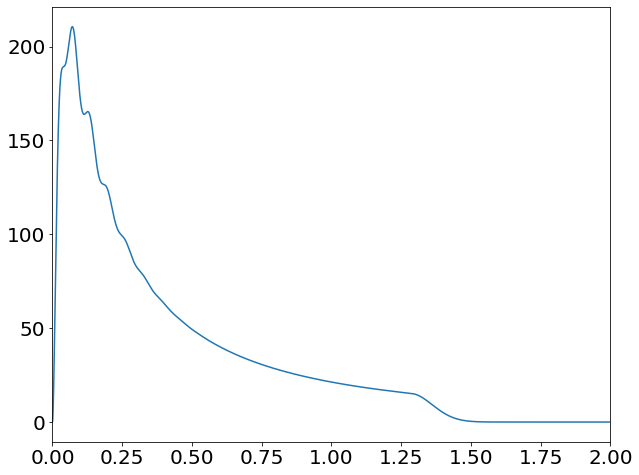

In [10]:
plt.plot(k, k*pkdamped(k))
plt.xlim((0, 2))

In [11]:
model = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=0)

model1 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=0)
model1.set_pk_model(pk=pkdamped)

model2 = SplitCCFModel(k, redshift=z, cosmology=cosmo_abacus, bias=1.8, nsplits=1, shot_noise=shot_noise)
model2.set_pk_model(pk=pkdamped)

## Particle density distribution

In [12]:
x = np.linspace(-3, 3, 100)
particle_density_model = norm.pdf(x, 0, model.sigma_RR)
particle_density_model1 = norm.pdf(x, 0, model1.sigma_RR)
particle_density_model2 = norm.pdf(x, 0, model2.sigma_RR)

In [13]:
np.std(mock_density.data_densities)

0.5407629432918505

In [14]:
model2.sigma_RR

0.5288206068616631

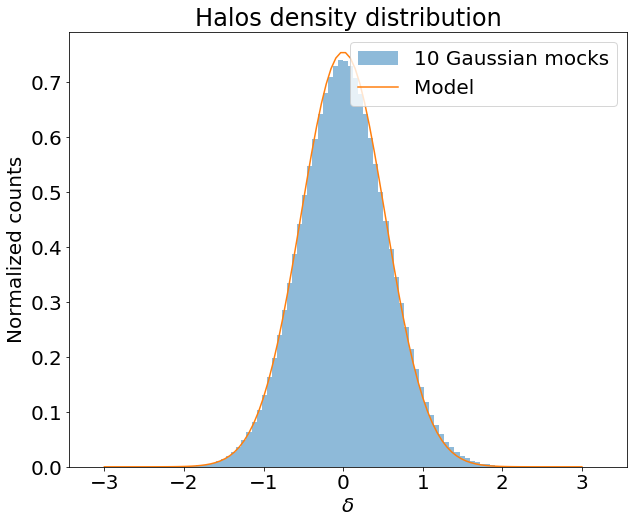

In [15]:
plt.hist(np.ravel(data_densities), bins=100, density=True, alpha=0.5, label = r'10 Gaussian mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
#plt.plot(x, particle_density_model, label=r'Model (raw ps, no shot noise)')
#plt.plot(x, particle_density_model1, label=r'Model (no shot noise)', color='C1', ls='--')
plt.plot(x, particle_density_model2, label=r'Model', color='C1', ls='-')
plt.legend()
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.title('Halos density distribution')
plt.show()

## Spatial density distribution

In [16]:
x = np.linspace(-3, 3, 100)
spatial_density_model1 = norm.pdf(x, 0, model1.sigma_R)
spatial_density_model2 = norm.pdf(x, 0, model2.sigma_R)

In [17]:
np.std(np.array(mock_density.density_mesh).flatten())

0.7085959691616057

In [18]:
model2.sigma_R

0.7040412088127378

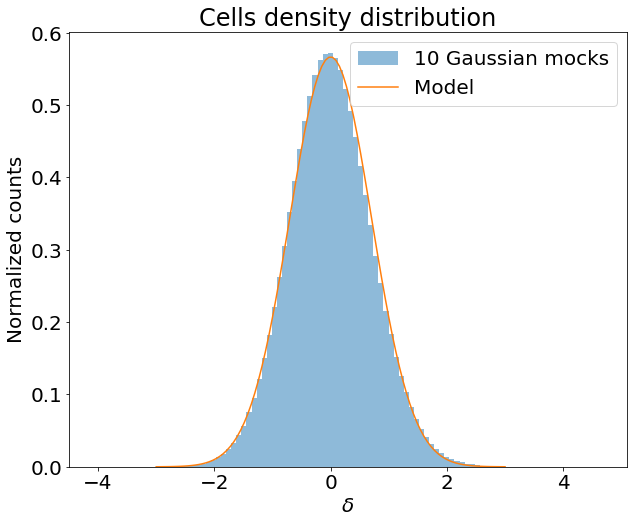

In [19]:
plt.hist(np.ravel(mesh_densities).flatten(), bins=100, density=True, alpha=0.5, label = r'10 Gaussian mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
#plt.plot(x, spatial_density_model1, label=r'Model (no shot noise)', color='C1', ls='--')
plt.plot(x, spatial_density_model2, label=r'Model', color='C1', ls='-')
plt.legend()
plt.title('Cells density distribution')
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.show()

## $\xi_{R}(s)$

In [20]:
mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_cellsize10_xi_R.npy', allow_pickle=True)

In [21]:
ells = [0]
nells = len(ells)

In [22]:
mocks_xiell, cov = get_poles(mocks_results, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(10)
s, _, res = mocks_results[0].get_corr(return_sep=True)

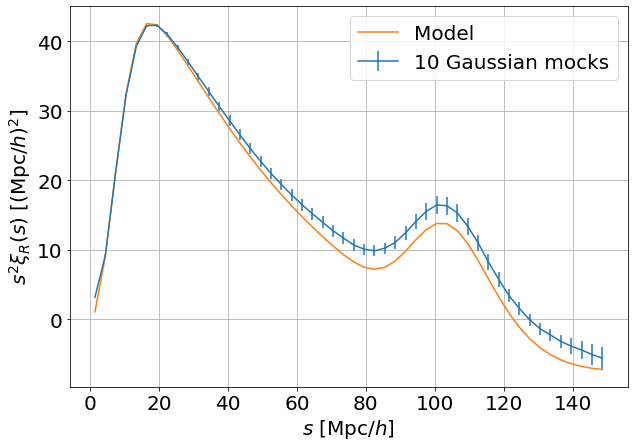

In [23]:
plt.rcParams["figure.figsize"] = (10, 7)

for ill, ell in enumerate(ells):
    plt.errorbar(s, s**2 * mocks_xiell[ill], s**2 * std[ill], fmt='-', label = r'10 Gaussian mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    #plt.plot(s, s**2 * model1.xi_R(s), label = 'Model (no shot noise)', ls='--', color='C1')
    plt.plot(s, s**2 * model2.xi_R(s), label = 'Model', ls='-', color='C1')
    plt.grid(True)

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.legend()
plt.show()

## $\xi(s)$

In [24]:
mocks_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_10_gaussianMocks_truncatedPk_nbarx5_cellsize10_2PCF.npy', allow_pickle=True)

In [25]:
ells = [0]
nells = len(ells)

In [26]:
mocks_xiell, cov = get_poles(mocks_results, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(10)
s, _, res = mocks_results[0].get_corr(return_sep=True)

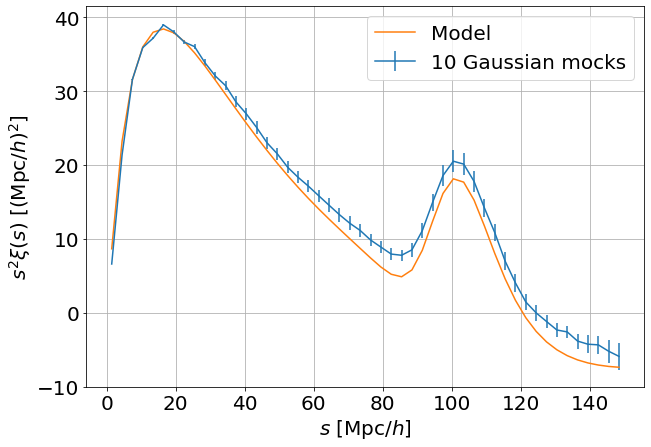

In [27]:
plt.rcParams["figure.figsize"] = (10, 7)

for ill, ell in enumerate(ells):
    plt.errorbar(s, s**2 * mocks_xiell[ill], s**2 * std[ill], fmt='-', label = r'10 Gaussian mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    #plt.plot(s, s**2 * model1.xi(s), label = 'Model (no shot noise)', ls='--', color='C1')
    plt.plot(s, s**2 * model2.xi(s), label = 'Model', ls='-', color='C1')
    plt.grid(True)

plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')

plt.legend()
plt.show()

## $\tilde{\delta}$

In [28]:
density_bins = np.array([-2.7709435 , -0.22492877,  0.23945293,  2.9611214 ])

In [29]:
delta_tilde = model2.compute_delta_tilde(density_bins)

In [34]:
delta_tilde*bg.growth_rate(z)

array([-0.51605139,  0.00611168,  0.52545908])

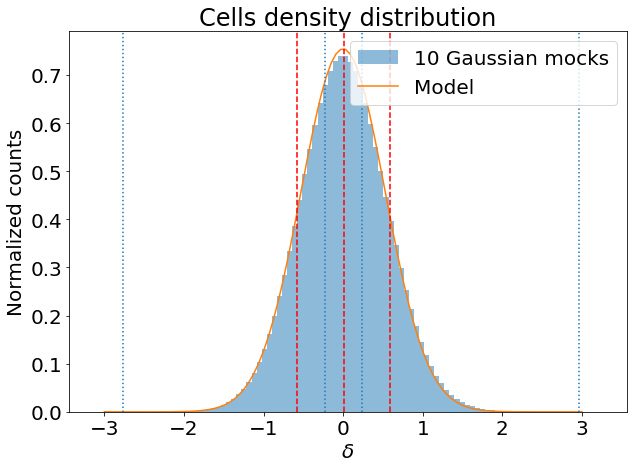

In [31]:
#plt.hist(np.ravel(mesh_densities).flatten(), bins=100, density=True, alpha=0.5, label = r'10 Gaussian mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
plt.hist(np.ravel(data_densities), bins=100, density=True, alpha=0.5, label = r'10 Gaussian mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
plt.plot(x, particle_density_model2, label=r'Model', color='C1', ls='-')
for i in range(len(density_bins)):
    plt.axvline(density_bins[i], ls=':')
for i in range(len(delta_tilde)):
    plt.axvline(delta_tilde[i], ls='--', color='red')
plt.legend()
plt.title('Cells density distribution')
plt.xlabel("$\delta$")
plt.ylabel("Normalized counts")
plt.show()